
# **GENETIC ALGORITHM FOR BATTLESHIP SOLITAIRE**

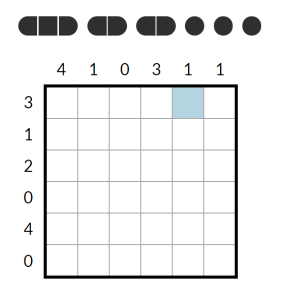
---

A 6×6 Battleship puzzle solved using genetic algorithm.

***Board Information:***
- N = 6
- Number of ships = 4
- Number and Types of ships: 1 Cruiser, 2 Destroyers, 3 Submarines
- Number of ship segments = 10
- Row-wise ship segment distribution: 3,1,2,1,2,1
- Column-wise ship segment distribution: 1,0,2,2,3,2
- 0s represent water and 1s represent ships




In [421]:
import time
import numpy as np
import random

start_time = time.time()

dim = 6

generation_limit = 15000
population_size = 15000
fitness_limit = 0.1

#Number of ship segments permitted:
row_constraints = [3,1,2,1,2,1]
col_constraints = [1,0,2,2,3,2]

# **Initial Population**
---
The initial population consists of two types of boards:
- rboard: A random board satisfying the constraints on the number of ships permitted in each row.
- cboard: A random board satisfying the constraints on the number of ships permitted in each column.
 
Each board in the initial population is converted into genetic code for further processing.

In [422]:
def rboard():
  board = np.zeros((dim, dim), dtype=int)
  for i in range(dim):
    count = 0
    randIdx = np.random.randint(dim)
    for j in range(randIdx,dim):
      if(count == row_constraints[i]):
        break
      count += 1
      board[i][j] = 1
      j += 1
    count = 0
    i += 1
  return board


In [423]:
def cboard():
  board = np.zeros((dim, dim), dtype=int)
  for j in range(dim):
    count = 0
    randIdx = np.random.randint(dim)
    for i in range(randIdx,dim):
      if(count == col_constraints[j]):
        break
      count += 1
      board[i][j] = 1
      i += 1
    count = 0
    j += 1
  return board

In [424]:
# Convert board into genetic code
def geneticCode(genome):
  # Genetic code: Convert 2D array of integers to 1D array of strings
    geneticSoln = ''.join(str(x) for x in genome.flatten())
    return geneticSoln

In [425]:
# Print genetic code as 2D array
def genome_to_board(genome):
  count = 0
  for i in range(dim):
    for j in range(dim):
      print(str(genome)[count], end = "    ")
      count += 1
    print(" |   " + str(row_constraints[i]))
    print("\n")
  for i in range(8):
   print("__", end = "  ")
  print("\n")
  for i in range(dim):
    print(col_constraints[i], end = "    ")


In [426]:
#List of population
def populationFunc():
  population = []
  for i in range (int(population_size)):
    pop = geneticCode(rboard())
    if  pop.count('1') == 10 :
      population.append(pop)
  for i in range (int(population_size/2)):
    pop = geneticCode(cboard())
    if  pop.count('1') == 10 :
      population.append(pop)
    np.random.shuffle(population)
  return population

# **Fitness Function**
---
Considering the rules of Battleship Solitaire, the constraints that can be used to calculate fitness scores are:
- Row and Column Constraints
- No Adjacency Constraint

In [427]:
#Fitness function
def fitness(genome):
  arr = np.zeros((dim, dim), dtype=int)
  count = 0
  for i in range(0, dim):
    for j in range(0, dim):
      arr[i][j] = int(genome[count])
      count +=1

  adjacent = 0
  i = 0
  j = 0
  while i < dim-1:
      while(j < dim):
          if(arr[i][j] == 1 and arr[i+1][j] == 1):
            adjacent += 1
          if(j == 0 and arr[i][j]==1 and arr[i+1][j+1]==1):
            adjacent += 1
          elif(j!=dim-1 and arr[i][j]==1 and arr[i+1][j+1]==1 and arr[i+1][j-1]==1):
            adjacent += 2
          elif(j!=dim-1 and arr[i][j]==1 and arr[i+1][j+1]==1): 
             adjacent += 1
          elif(j!=dim-1 and arr[i][j]==1 and arr[i+1][j-1]==1): 
            adjacent += 1 
          elif(j == dim-1 and arr[i][j]==1 and arr[i+1][j-1]==1):
            adjacent += 1
          elif(j!=dim-1 and arr[i][j]==1 and arr[i][j+1]==1):
            adjacent += 1
          j += 1
      j = 0  
      i += 1
  #Finding number of incorrect rows
  sum_row = 0
  sum_col = 0
  incorrect_rows = 0
  incorrect_cols = 0
  i = 0
  j = 0
  while i < dim:
    while j < dim:
      if(arr[i][j] == 1):
        sum_row += 1
      j += 1
    if(sum_row != row_constraints[i]):
      incorrect_rows += 1
    sum_row = 0
    j = 0
    i += 1
 #Finding number of incorrect columns  
  i = 0
  j = 0
  while j < dim:
      while i < dim:
        if(arr[i][j] == 1):
          sum_col += 1
        i += 1
      if(sum_col != col_constraints[j]):
        incorrect_cols += 1
      sum_col = 0
      i = 0
      j += 1
   
  if (adjacent+ incorrect_rows + incorrect_cols) == 0:
     return float('inf')
  return 1/(adjacent + incorrect_rows + incorrect_cols)


# **Selection Function**
---
A selection function is used to determine two random parents for generating the next generation.

In [428]:
#Selection function
import random
def selectionFunc(population, fitness):
  if len(population)!=0:
    return random.choices(
      population = population,
      weights = [fitness(genome) for genome in population],
      k = 2
  )

# **Crossover Function**
---
1-point crossover can be performed over the parents to generate offsprings. 

In [429]:
#1-point crossover
def crossover(g1, g2):
  if(len(g1)!=len(g2)):
     return -1
  if(len(g1)<2):
     return g1, g2
  index = random.randint(0, len(g1)-1)
  if (g1[0:index]+g2[index:]).count('1') == 10 and (g2[0:index]+g1[index:]).count('1') == 10:
    return g1[0:index]+g2[index:], g2[0:index]+g1[index:]
  else:
    return g1, g2

# **Mutation**
---
In mutation, a random bit is toggled to produce a new variant. However, toggling a single bit would change the number of ship segments on the board. So, the mutation function is modified such that two random bits are toggled. 

In [430]:
#Mutation
def mutation(genome):
    index = random.randrange(len(genome)-1)
    index2 = random.randrange(len(genome)-1)

    if genome[index] == 0 and genome[index+1] == 1:
       abs(genome[index] - 1)  
       abs(genome[index+1]-1)
    elif genome[index] == 1 and genome[index+1] == 0:
       abs(genome[index] - 1)  
       abs(genome[index+1]-1)

    return genome

# **Evolution**
---
The evolution over the generations is carried out to generate the final solution.

In [431]:
#Run Evolution
def runEvolution():
    population = populationFunc()
    for i in range(generation_limit):
      population = sorted(population, key = lambda genome:fitness(genome),reverse = True)
      #if fitness limit reached
      if(len(population)!=0):
       if(fitness(population[0])>=fitness_limit):
          break
      #next gen = top 2 (elitism)
      if(len(population)>=2):
        next_gen = population[0:2]
      for j in range(int(len(population)/2)-1):
        parents = selectionFunc(population, fitness)
        if(parents!=None):
          offspring1, offspring2 = crossover(parents[0], parents[1])
          offspring1 = mutation(offspring1)
          offspring2 = mutation(offspring2)
          next_gen += [offspring1, offspring2] 
          population = next_gen
          population = sorted(population, key = lambda genome: fitness(genome),reverse = True)
    return population

In [432]:
#Run evolution to find the solution
a = runEvolution()
print("Battleship Puzzle Solution\n")
genome_to_board(a[0])

Battleship Puzzle Solution

0    0    0    1    1    1     |   3


1    0    0    0    0    0     |   1


0    0    0    1    1    0     |   2


0    0    1    0    0    0     |   1


0    0    0    0    1    1     |   2


0    0    1    0    0    0     |   1


__  __  __  __  __  __  __  __  

1    0    2    2    3    2    

In [433]:
end_time = time.time()
print(end_time-start_time)

6.76453709602356


# **RESULTS AND CONCLUSION**
---
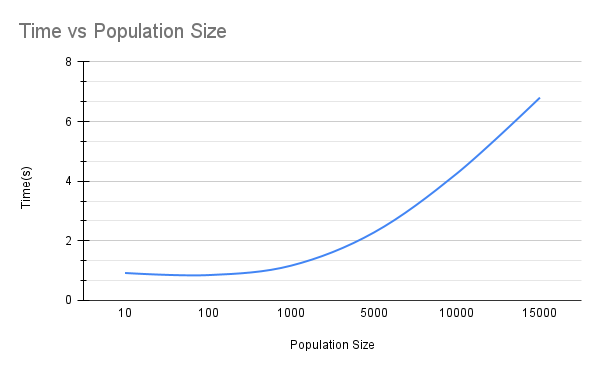
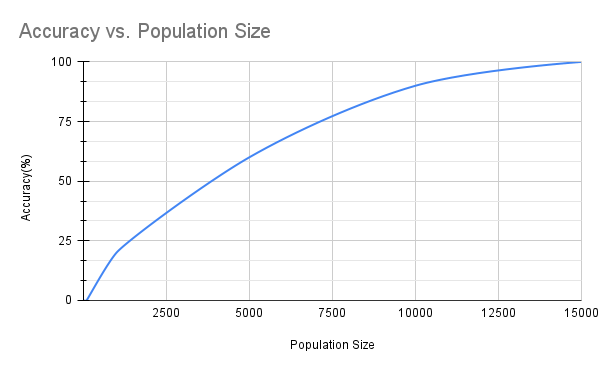
---
After running the algorithm with population size and generation limit in the range 10-15000, a significant increase in the accuracy was observed. However, an increase in these two paramenters also increased the average run time of the program from 0.921 seconds to 6.803 seconds.
